# Boosted trees x KModes

In [1]:
import numpy as np
import pandas as pd

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss, roc_curve, roc_auc_score, zero_one_loss, classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from matplotlib import pyplot
from imblearn.under_sampling import NearMiss
from imblearn.pipeline import Pipeline, make_pipeline

## Data preperation

In [2]:
#Reading the file and splitting our target column
train_data = pd.read_csv (r'bank-additional-trainclusters.csv')   
test_data = pd.read_csv (r'bank-additional-testclusters.csv')   

train_targets= train_data['onehotencoder__y_yes']
train_features = train_data.drop(columns=['onehotencoder__y_yes']).values

test_targets= test_data['onehotencoder__y_yes']
test_features = test_data.drop(columns=['onehotencoder__y_yes']).values

## Grid search hyperparameter tuning

In [3]:
# define hyperparameter search space
learning_rate = [0.1, 0.01, pow(10,-3), pow(10,-4), pow(10,-5), pow(10,-6)] 
max_depth = [1,2,3,4,5,6,7,8]
n_estimators = range(1,5002, 1000)

# create dictionary from search space
grid = dict(
    gradientboostingclassifier__max_depth=max_depth,
    gradientboostingclassifier__learning_rate=learning_rate,
    gradientboostingclassifier__n_estimators=n_estimators,
)

# create 10-fold cross validation generator
cv = KFold(n_splits=10)

# create imbalanced learn pipeline
imba_pipeline = make_pipeline(NearMiss(version=1), GradientBoostingClassifier(max_depth=1, 
                                                                                 learning_rate = 0.1,
                                          n_estimators= 123 ,random_state=23))
#cross_val_score(imba_pipeline, X_train, y_train, scoring='roc_auc', cv=cv)
                              

# create random searcher with 10-fold cv and start tuning process
model_grid = GridSearchCV(estimator=imba_pipeline, param_grid=grid, n_jobs=1, cv=cv, verbose=2, scoring='roc_auc')
grid_res = model_grid.fit(train_features, train_targets)

# summarise grid search info
bestScore = grid_res.best_score_
bestParams = grid_res.best_params_
print("[INFO] best score is {:.2f} using {}".format(bestScore,
    bestParams))

Fitting 10 folds for each of 288 candidates, totalling 2880 fits
[CV] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=1, gradientboostingclassifier__n_estimators=1; total time=   1.8s


KeyboardInterrupt: 

In [6]:
print("[INFO] best score is {:.2f} using {}".format(bestScore, bestParams))

[INFO] best score is 0.76 using {'gradientboostingclassifier__learning_rate': 0.001, 'gradientboostingclassifier__max_depth': 1, 'gradientboostingclassifier__n_estimators': 1001}


## Undersample training data for further analysis

In [3]:
# underfit training data using nearmiss 1
nm = NearMiss(version = 1)
x_res, y_res = nm.fit_resample(train_features, train_targets)
train_features.shape,x_res.shape

((32950, 25), (7506, 25))

## Overfit Analysis

In [4]:
#Now we set our n_estimator and learning_rate to the optimal value found in the last grid search
learningRate = 0.001
nEstimator = 1001
maximumDepth = 1

#### Check for overfitting by varying learning rate

Learning rate: 0.100000, train: 0.860, test: 0.543
Learning rate: 0.010000, train: 0.815, test: 0.617
Learning rate: 0.001000, train: 0.800, test: 0.688
Learning rate: 0.000100, train: 0.798, test: 0.702
Learning rate: 0.000010, train: 0.798, test: 0.702
Learning rate: 0.000001, train: 0.798, test: 0.702


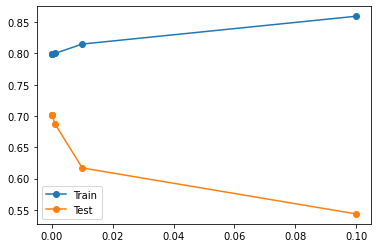

In [11]:
# define lists to collect scores
train_scores, test_scores = list(), list()

# define the learning rate to evaluate
values = [0.1, 0.01, pow(10,-3), pow(10,-4), pow(10,-5), pow(10,-6)]
# evaluate a decision tree for learning rate
for i in values:
    # configure the model
    model = GradientBoostingClassifier(max_depth=maximumDepth, learning_rate = i, n_estimators=nEstimator, random_state=23).fit(
        x_res, y_res)
    # evaluate on the train dataset
    schatting = model.predict(x_res)
    train_acc = roc_auc_score(y_res, schatting)
    train_scores.append(train_acc)
    # evaluate on the test dataset
    test_schatting = model.predict(test_features)
    test_acc = roc_auc_score(test_targets, test_schatting)
    test_scores.append(test_acc)
    # summarize progress
    print('Learning rate: %.6f, train: %.3f, test: %.3f' % (i, train_acc, test_acc))
# plot of train and test scores vs learning rate
pyplot.plot(values, train_scores, '-o', label='Train')
pyplot.plot(values, test_scores, '-o', label='Test')
pyplot.legend()
pyplot.show()

#### Check for overfitting by varying number of estimators

n_estimator: 1, train: 0.798, test: 0.702
n_estimator: 101, train: 0.798, test: 0.702
n_estimator: 201, train: 0.798, test: 0.702
n_estimator: 301, train: 0.798, test: 0.702
n_estimator: 401, train: 0.798, test: 0.702
n_estimator: 501, train: 0.798, test: 0.702
n_estimator: 601, train: 0.800, test: 0.688
n_estimator: 701, train: 0.800, test: 0.688
n_estimator: 801, train: 0.800, test: 0.688
n_estimator: 901, train: 0.800, test: 0.688
n_estimator: 1001, train: 0.800, test: 0.688
n_estimator: 1101, train: 0.800, test: 0.688
n_estimator: 1201, train: 0.800, test: 0.688
n_estimator: 1301, train: 0.800, test: 0.688
n_estimator: 1401, train: 0.800, test: 0.688
n_estimator: 1501, train: 0.800, test: 0.688
n_estimator: 1601, train: 0.800, test: 0.688
n_estimator: 1701, train: 0.800, test: 0.688
n_estimator: 1801, train: 0.810, test: 0.685
n_estimator: 1901, train: 0.810, test: 0.685
n_estimator: 2001, train: 0.810, test: 0.685
n_estimator: 2101, train: 0.811, test: 0.685
n_estimator: 2201, tra

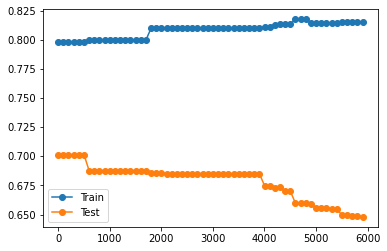

In [12]:
#Check for overfitting with n_estimators

# define lists to collect scores
train_scores, test_scores = list(), list()

# define the estimators to evaluate
values = [i for i in range(1, 6001, 100)]
# evaluate a decision tree for estimator
for i in values:
    # configure the model
    model = GradientBoostingClassifier(max_depth=maximumDepth, learning_rate = learningRate, n_estimators=i, random_state=23).fit(
        x_res, y_res)
    # evaluate on the train dataset
    schatting = model.predict(x_res)
    train_acc = roc_auc_score(y_res, schatting)
    train_scores.append(train_acc)
    # evaluate on the test dataset
    test_schatting = model.predict(test_features)
    test_acc = roc_auc_score(test_targets, test_schatting)
    test_scores.append(test_acc)
    # summarize progress
    print('n_estimator: %.0f, train: %.3f, test: %.3f' % (i, train_acc, test_acc))
# plot of train and test scores vs n_estimator
pyplot.plot(values, train_scores, '-o', label='Train')
pyplot.plot(values, test_scores, '-o', label='Test')
pyplot.legend()
pyplot.show()

#### Check for overfitting by varying maximum tree depth

tree depth: 1, train: 0.800, test: 0.688
tree depth: 2, train: 0.814, test: 0.680
tree depth: 3, train: 0.828, test: 0.621
tree depth: 4, train: 0.846, test: 0.596
tree depth: 5, train: 0.873, test: 0.579
tree depth: 6, train: 0.882, test: 0.564
tree depth: 7, train: 0.892, test: 0.557
tree depth: 8, train: 0.895, test: 0.547


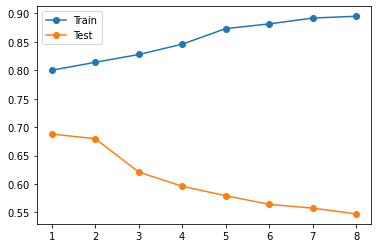

In [13]:
# define lists to collect scores
train_scores, test_scores = list(), list()

# define the estimators to evaluate
values = [1,2,3,4,5,6,7,8]
# evaluate a decision tree for estimator
for i in values:
    # configure the model
    model = GradientBoostingClassifier(max_depth=i, learning_rate = learningRate, n_estimators=nEstimator, random_state=23).fit(
        x_res, y_res)
    # evaluate on the train dataset
    schatting = model.predict(x_res)
    train_acc = roc_auc_score(y_res, schatting)
    train_scores.append(train_acc)
    # evaluate on the test dataset
    test_schatting = model.predict(test_features)
    test_acc = roc_auc_score(test_targets, test_schatting)
    test_scores.append(test_acc)
    # summarize progress
    print('tree depth: %.0f, train: %.3f, test: %.3f' % (i, train_acc, test_acc))
# plot of train and test scores vs n_estimator
pyplot.plot(values, train_scores, '-o', label='Train')
pyplot.plot(values, test_scores, '-o', label='Test')
pyplot.legend()
pyplot.show()

## Run final model on test data to get AUC

In [4]:
# best hyperparameters
learning_rate = 0.001
max_depth = 1
n_estimators = 1001

mean cross validation score: 0.838
Confusion Matrix:
[[4559 2792]
 [ 217  670]]
Classification Report
              precision    recall  f1-score   support

         0.0       0.95      0.62      0.75      7351
         1.0       0.19      0.76      0.31       887

    accuracy                           0.63      8238
   macro avg       0.57      0.69      0.53      8238
weighted avg       0.87      0.63      0.70      8238



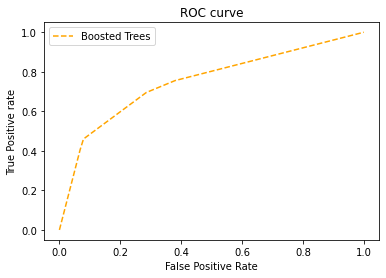

AUC Score: 0.751


In [5]:
# Boosted trees model
ensemble = GradientBoostingClassifier(max_depth=max_depth, learning_rate = learning_rate,
                                          n_estimators= n_estimators ,random_state=23)
    
k = 10
kf = KFold(n_splits=k, shuffle = True)

dt_scores = cross_val_score(ensemble, x_res, y_res, scoring ='roc_auc' ,cv = kf)
print("mean cross validation score: {}".format(np.round(np.mean(dt_scores),3)))

ensemble.fit(x_res, y_res)
predictions = ensemble.predict(test_features)
    
print("Confusion Matrix:")
print(confusion_matrix(test_targets, predictions))

print("Classification Report")
print(classification_report(test_targets, predictions))
    
#Beginning the plotting of ROC-curve
pred_prob = ensemble.predict_proba(test_features)
fpr, tpr, thresh = roc_curve(test_targets, pred_prob[:,1], pos_label=1)
    
#Plot roc curves
plt.plot(fpr, tpr, linestyle='--',color='orange', label='Boosted Trees')

# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();
    
#AUC Score
auc_score = roc_auc_score(test_targets, pred_prob[:,1])
print("AUC Score: " + str(np.round(auc_score , 3)))